In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import concat
import pandas_datareader as data
from pandas_datareader import data as pdr
import seaborn as sns
import matplotlib.dates as mdates

from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import tensorflow

In [16]:
#creating a start date and end date
start = '2010-01-01'
end =  datetime.today().strftime("%Y-%m-%d")
#end = '2019-12-31'
yf.pdr_override()
company = 'AAPL'
#creating the dataframe
df= pdr.get_data_yahoo(company, start, end)

#getting the first 5 rows and the last 5 rows
print(df.head(5))
print(df.tail(5))

df.shape

[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.515212  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.526476  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.422665  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.410791  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.453412  447610800
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-12-28  129.669998  131.029999  125.870003  126.040001  126.040001   
2022-12-29  127.989998  130.479996  127.730003  129.610001  129.610001   
2022-12-30  128.410004  129.949997  127.430000  129.929993  129.929993   
2023-01-03  130.279999  130.899994  124.169998  12

(3274, 6)

In [17]:
#dropping the adj close column as it is not needed since it similar to the close column and also the date column
#df = df.reset_index()
df.head()
#df = df.drop(['Date','Adj Close'], axis=1)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515212,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422665,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410791,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453412,447610800


In [ ]:
#checking if there are any missing datas
missing_data = df[df.isna().any(axis=1)]
print(missing_data)
df.info()
print(df.shape)

Exploring the stock datasets

In [ ]:
#Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        #ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

Open         1.328310
High         1.328371
Low          1.327524
Close        1.327844
Adj Close    1.331053
Volume       2.036590
dtype: float64
               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999893  0.999863  0.999711   0.999655 -0.499332
High       0.999893  1.000000  0.999843  0.999864   0.999816 -0.497925
Low        0.999863  0.999843  1.000000  0.999870   0.999805 -0.501544
Close      0.999711  0.999864  0.999870  1.000000   0.999941 -0.499817
Adj Close  0.999655  0.999816  0.999805  0.999941   1.000000 -0.498855
Volume    -0.499332 -0.497925 -0.501544 -0.499817  -0.498855  1.000000


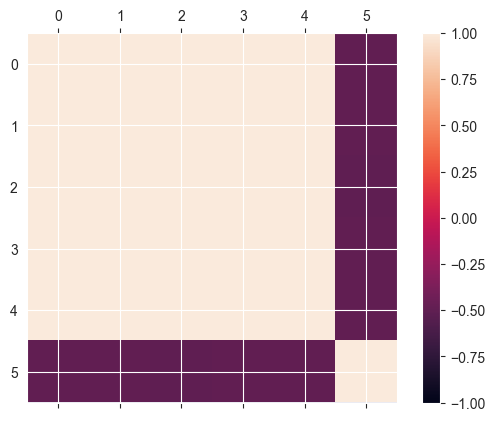

In [18]:
#checking how much skewness
print(df.skew())

#checking the correlations between the data
df_corr = df.corr(method='pearson')
print(df_corr)

#using correlation matrix plot
corr_fig = plt.figure()
axises = corr_fig.add_subplot(111)
axcorr = axises.matshow(df_corr, vmin=-1, vmax=1)

corr_fig.colorbar(axcorr)
ticks = np.arange(0,6,1)

#setting ticks for each axis
axises.set_xticks(ticks)
axises.set_yticks(ticks)

plt.show()

checking for outliers

In [ ]:
#checking if there is any outliers in the dataset
#use the simple imputer function to replace the empty values in the dataframe



import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,9))

# Create a boxplot of the data
sns.boxplot(data=df)
# Show the plot
plt.show()

In [ ]:
from sklearn.impute import SimpleImputer
# Find the rows containing null values
outliers = df[df.isnull().any(axis=1)]

# Drop the rows containing null values
df = df.drop(outliers.index)

#use the simple imputer function to replace the empty values in the dataframe

#creating a header for the names
header_names = ['High','Low','Open','Close','Volume','Adj Close']

imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df)
new_dataa = imputer.transform(df)

#convert the data back to a dataframe and bind the headers
df = pd.DataFrame(new_dataa, columns=header_names)

# Preview d data after removing the rows containing null values
df.head()

In [ ]:
#splitting the data into training and testing
train_header = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
target_header = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])
print(df.shape)
print(train_header.shape)
print(target_header.shape)

In [ ]:
#Scaling the stock data so that they fit inbetween 0 and 1
from sklearn.preprocessing import MinMaxScaler
from numpy import set_printoptions
scaler = MinMaxScaler(feature_range=(0,1))
train_header_array = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

train_header_array


In [ ]:
#define how many days in the past we will look into
#the closing price of the particular day would depend on the previous days
historical_data = 50

#########################
# PREPARING TRAINING DATA
#########################
x_train = []
y_train = []

for x in range(historical_data, train_header_array.shape[0]):
    x_train.append(train_header_array[x - historical_data:x, 0])
    y_train.append((train_header_array[x, 0])) #because we are considering only one column

# turning x and y train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [ ]:
# now we are going to reshape the x_train so that it works with the neural network
# the 1 indicates one additional dimension
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
##################
# INSTANTIATE THE MODEL
##################
model = Sequential()

# now we can specify the layers - always add 1 LSTM layer and then a Dropout layer rinse/repeat the final layer is
# the Dense layer that is going to be just one unit, and it's going to the stock price prediction

model.add(LSTM(units=50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units =60, activation = 'relu', return_sequences = True,))
model.add(Dropout(0.3))
model.add(LSTM(units =80, activation = 'relu', return_sequences = True, ))
model.add(Dropout(0.4))
model.add(LSTM(units =120, activation = 'relu'))
model.add(Dropout(0.5))
# prediction of the next closing price
model.add(Dense(units = 1))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics = ['mae'])
epochs = 25
history=model.fit(x_train, y_train, epochs=epochs)


# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

SAVE THE MODEL SO IT WOULD BE USEFUL IN STREAMLIT

In [ ]:

model.save('neww_lstm_model.h5')

Feature importance using permutation importance

In [19]:
import innvestigate

# Create an LRP analyzer
analyzer = innvestigate.create_analyzer("lrp.alpha_1_beta_0", model)

# Calculate the feature importances for a single sample
x = x_train[0]  # select a single sample from the training data
relevances = analyzer.analyze(x).sum(axis=2)

# Print the feature importances
print(relevances)

NameError: name 'model' is not defined

In [ ]:
# LOAD THE DATA - it has to be data the model has not seen before
# this is the time range of the data - we have the data but the model has never seen that data
# so this is a perfect way to see how well it performs
_start = '2010-01-01'
_end = datetime.today().strftime("%Y-%m-%d")
_data = pdr.get_data_yahoo(company, _start, _end)

In [ ]:
#getting the actual prices
# we need to scale prices, we need to concatenate the full data set that we want to predict on
# this is NOT the predicted price, but the real price from the market
actual_prices = _data['Close'].values

In [ ]:
# this will combine the training data and the test data
total_dataset = pd.concat((df['Close'], _data['Close']), axis=0)


In [ ]:
# this is what our model is going to see as an input, so it can predict
model_inputs = total_dataset[len(total_dataset) - len(_data) - historical_data:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


MAKE PREDICTIONS ON TEST DATA

In [ ]:
###############################
# MAKE PREDICTIONS ON TEST DATA
###############################

# we don't use the y_test because we already have the stock prices
x_test = []
y_test = []
# if you remove the + 1 it will remove the newest data
for x in range(historical_data, len(model_inputs)):
    x_test.append(model_inputs[x - historical_data:x, 0])
    y_test.append(model_inputs[i, 0])

x_test,y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))



In [ ]:
# now let's predict on the x_test data,the predicted prices are now going to be scaled, so we need to reverse scale them or rather inverse_transform them
y_pred = model.predict(x_test)
# now we are back to the actual predicted price, non-scaled
y_pred = scaler.inverse_transform(y_pred)

# now let plot the predictions instead of just numbers.
plt.plot(actual_prices, color="red", label=f"Actual {company} Price")
plt.plot(y_pred, color="blue", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
# you can also do .pdf for a vector like file (super zoomy)
plt.savefig('Prediction_test.svg')
# this acts as a 'end conn' situation
plt.show()

EVALUATING THE MODEL PERFORMANCES

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#evaluate the model
mae = mean_absolute_error(actual_prices, y_pred)
mse = mean_squared_error(actual_prices, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, y_pred)



#printing the model evaluation values
print('mae:  {:.2f}'.format(mae))
print('mse:  {:.2f}'.format(mse))
print('Root mean square error:  {:.2f}'.format(rmse))
print('R2 score: ', r2)




Making Predictions for Next day

In [ ]:
#########################
# PREDICTING OUR NEXT DAY
#########################

final_data = [model_inputs[len(model_inputs) + 1 - historical_data:len(model_inputs + 1), 0]]
final_data = np.array(final_data)
final_data = np.reshape(final_data, (final_data.shape[0], final_data.shape[1], 1))

print(scaler.inverse_transform(final_data[-1]))

Next_day = model.predict(final_data)
Next_day  = scaler.inverse_transform(Next_day)
print(f' Price Prediction for tomorrow would be: {Next_day}')